In [1]:
import pandas as pd #数据分析
import numpy as np #科学计算
from pandas import Series,DataFrame
import seaborn as sns
train_identity = pd.read_csv('./train_identity.csv')
train_transaction = pd.read_csv('./train_transaction.csv')
test_identity = pd.read_csv('./test_identity.csv')
test_transaction = pd.read_csv('./test_transaction.csv')

train_full = pd.merge(train_identity, train_transaction, on = 'TransactionID')
train_operation = train_full
data_test=pd.merge(test_identity, test_transaction, on = 'TransactionID')

In [2]:
data_null = train_full.isnull().sum()
data_null = data_null.drop(data_null[data_null == 0].index).sort_values(ascending=False)

data_null = data_null / train_full.shape[0] * 100

print("非空列有{0}个 空列占比{1}%".format(train_full.shape[1] - len(data_null), len(data_null) / train_full.shape[1] * 100))
null_rate = 0.75 * 100

print("null rate >= {0} 的列有{1}个，占比总null列{2:.5f}%".format(null_rate, np.sum(data_null > null_rate), \
                                                     np.sum(data_null > null_rate) / data_null.shape[0]  * 100 ))

train_operation = train_operation.drop(data_null[data_null > null_rate].index, axis=1)
data_test = data_test.drop(data_null[data_null > null_rate].index, axis=1)

非空列有22个 空列占比94.93087557603687%
null rate >= 75.0 的列有33个，占比总null列8.00971%


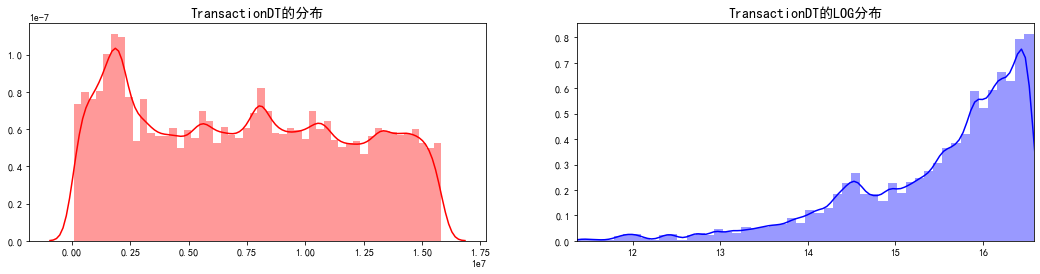

In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction['TransactionDT'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('TransactionDT的分布', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('TransactionDT的LOG分布', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

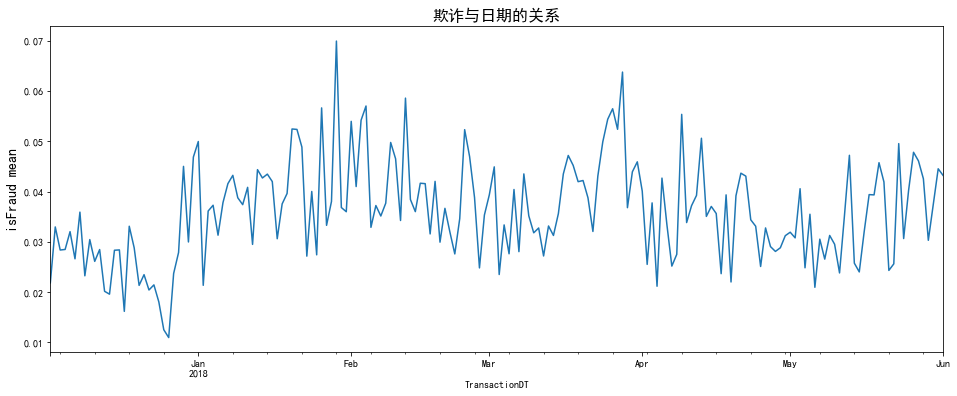

In [4]:
import datetime
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
train_transaction['TransactionDT'] = train_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test_transaction['TransactionDT'] = test_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
train_transaction.set_index('TransactionDT').resample('D').mean()['isFraud'].plot(ax=axes).set_ylabel('isFraud mean', fontsize=14);
axes.set_title('欺诈与日期的关系', fontsize=16);

In [5]:
def plot_categorical(train: pd.DataFrame, test: pd.DataFrame, feature: str, target: str, values: int=5):
    """
         train（pandas.DataFrame）：训练集
         test（pandas.DataFrame）：测试集
         feature（str）：要素的名称
         target（str）：目标要素的名称
         values（int）：要查看的大多数frequest值的数量
    """
    df_train = pd.DataFrame(data={feature: train[feature], 'isTest': 0})
    df_test = pd.DataFrame(data={feature: test[feature], 'isTest': 1})
    df = pd.concat([df_train, df_test], ignore_index=True)
    df = df[df[feature].isin(df[feature].value_counts(dropna=False).head(values).index)]
    train = train[train[feature].isin(train[feature].value_counts(dropna=False).head(values).index)]
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    sns.countplot(data=df.fillna('NaN'), x=feature, hue='isTest', ax=axes[0]);
    g=sns.countplot(data=train[[feature, target]].fillna('NaN'), x=feature, hue=target, ax=axes[1]);
    axes[0].set_title('训练/测试{}最常见值的分布'.format(values));
    axes[1].set_title('训练{}最常见值的分布'.format(target, values));
    axes[0].legend(['训练', '测试']);
    total = len(df)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

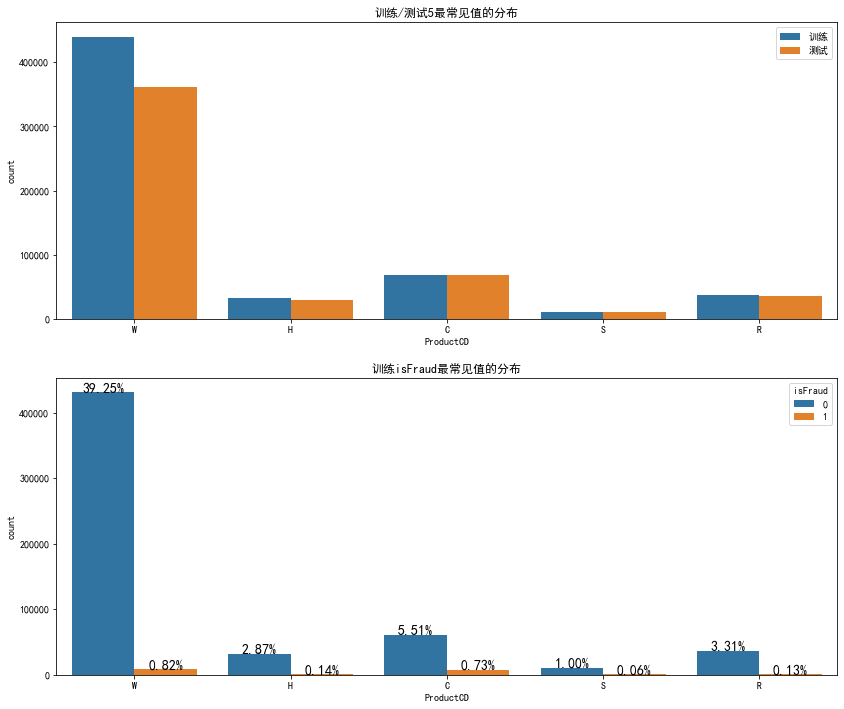

In [6]:
plot_categorical(train_transaction, test_transaction, 'ProductCD', 'isFraud')

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

<Figure size 1152x648 with 0 Axes>

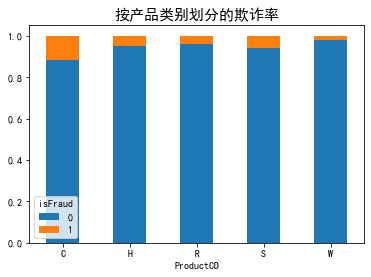

In [7]:
plt.figure(figsize=(16,9))
a = train_transaction.groupby('ProductCD')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
a.set_title('按产品类别划分的欺诈率', fontsize = 15)
plt.xticks(rotation='horizontal')

Text(0, 0.5, '欺诈率')

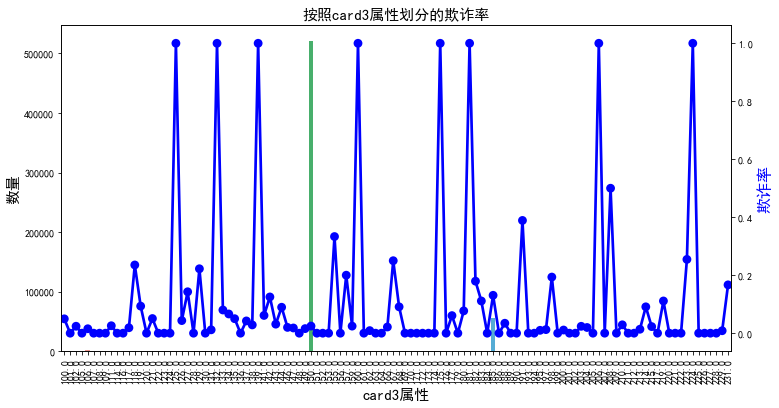

In [8]:
card3_fraud_rate = train_transaction.groupby('card3')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'card3', data = train_transaction)
g.set_title('按照card3属性划分的欺诈率', fontsize = 15)
g.set_xlabel("card3属性", fontsize=15)
g.set_ylabel("数量", fontsize=15)
plt.xticks(rotation='vertical')

r = g.twinx()
r = sns.pointplot(x = card3_fraud_rate.index, y = card3_fraud_rate, color = 'blue')
r.set_ylabel("欺诈率", fontsize = 16, color = "blue")

Text(0, 0.5, '欺诈率')

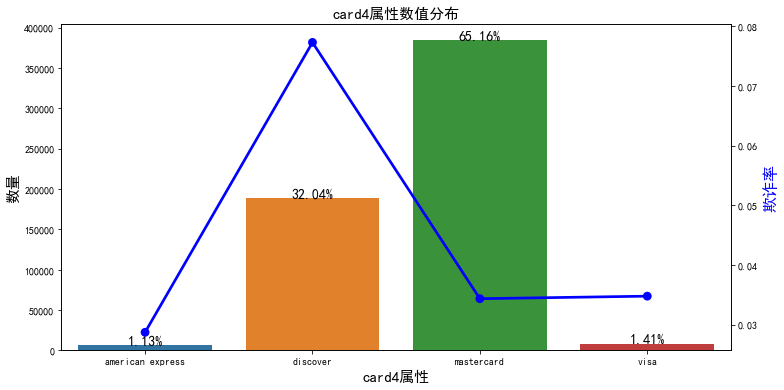

In [9]:
plt.figure(figsize=(12,6))
card4_fraud_rate = train_transaction.groupby('card4')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]
total = len(train_transaction)

g = sns.countplot(x = 'card4', data = train_transaction)
g.set_title('card4属性数值分布', fontsize = 15)
g.set_xlabel("card4属性", fontsize=15)
g.set_ylabel("数量", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
    
r = g.twinx()
r = sns.pointplot(x = card4_fraud_rate.index, y = card4_fraud_rate, color = 'blue')
r.set_ylabel("欺诈率", fontsize = 16, color = "blue")

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

<Figure size 1296x432 with 0 Axes>

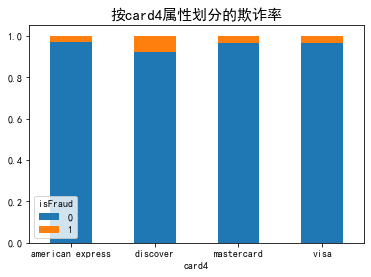

In [10]:
plt.figure(figsize=(18,6))
a = train_transaction.groupby('card4')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
a.set_title('按card4属性划分的欺诈率', fontsize = 15)
plt.xticks(rotation='horizontal')

Text(0, 0.5, '欺诈率')

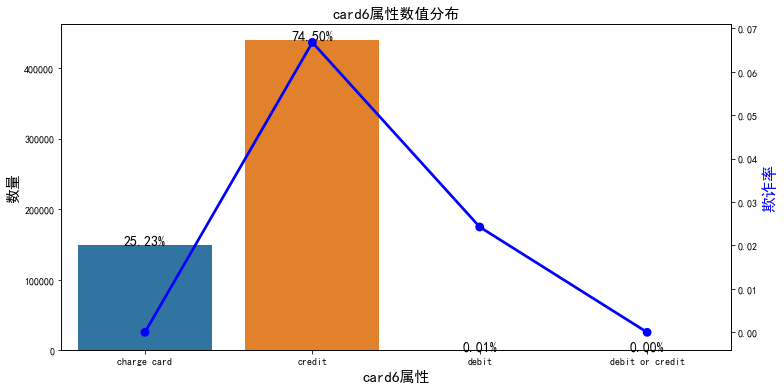

In [11]:
plt.figure(figsize=(12,6))
card6_fraud_rate = train_transaction.groupby('card6')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

total = len(train_transaction)

g = sns.countplot(x = 'card6', data = train_transaction)
g.set_title('card6属性数值分布', fontsize = 15)
g.set_xlabel("card6属性", fontsize=15)
g.set_ylabel("数量", fontsize=15)f
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
r = g.twinx()
r = sns.pointplot(x = card6_fraud_rate.index, y = card6_fraud_rate, color = 'blue')
r.set_ylabel("欺诈率", fontsize = 16, color = "blue")

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

<Figure size 864x432 with 0 Axes>

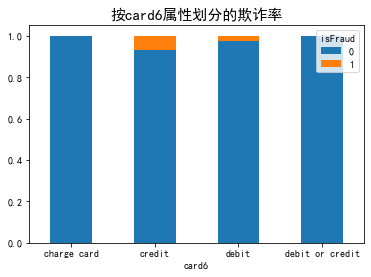

In [12]:
plt.figure(figsize=(12,6))
a = train_transaction.groupby('card6')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
a.set_title('按card6属性划分的欺诈率', fontsize = 15)
plt.xticks(rotation='horizontal')

Text(0, 0.5, '欺诈率')

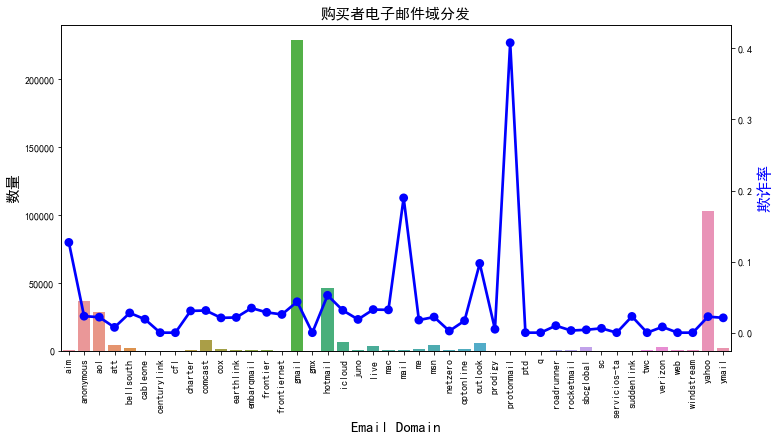

In [13]:
train_transaction["P_parent_emaildomain"] = train_transaction["P_emaildomain"].str.split('.', expand = True)[[0]]
P_emaildomain_fraud_rate = train_transaction.groupby('P_parent_emaildomain')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'P_parent_emaildomain', data = train_transaction, order = P_emaildomain_fraud_rate.index)
g.set_title('购买者电子邮件域分发', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("数量", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = P_emaildomain_fraud_rate.index, y = P_emaildomain_fraud_rate, color = 'blue')
r.set_ylabel("欺诈率", fontsize = 16, color = "blue")

Text(0, 0.5, '欺诈率')

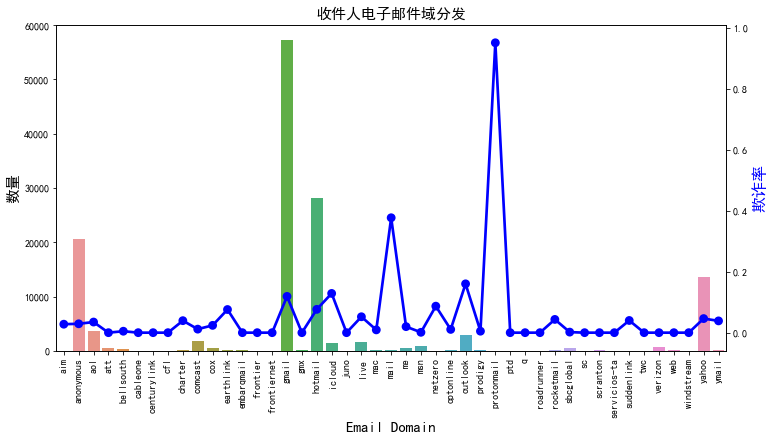

In [14]:
train_transaction["R_parent_emaildomain"] = train_transaction["R_emaildomain"].str.split('.', expand = True)[[0]]
fraud_rate = train_transaction.groupby('R_parent_emaildomain')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'R_parent_emaildomain', data = train_transaction, order = fraud_rate.index)
g.set_title('收件人电子邮件域分发', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("数量", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = fraud_rate.index, y = fraud_rate, color = 'blue')
r.set_ylabel("欺诈率", fontsize = 16, color = "blue")

In [15]:
def visualize_cat_cariable(variable, df=train_full):
    train_full[variable].fillna("NaN", inplace=True)
    variable_fraud_rate = df.groupby(variable)['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]
    
    plt.figure(figsize=(12,6))

    g = sns.countplot(x = variable, data = df, order = variable_fraud_rate.index)
    g.set_title('按{} 属性划分的欺诈率'.format(variable), fontsize = 15)
    g.set_xlabel("{}".format(variable), fontsize=15)
    g.set_ylabel("数量", fontsize=15)
    plt.xticks(rotation= "vertical")

    r = g.twinx()
    r = sns.pointplot(x = variable_fraud_rate.index, y = variable_fraud_rate, color = "blue")
    r.set_ylabel("欺诈率", fontsize = 16, color = "blue")

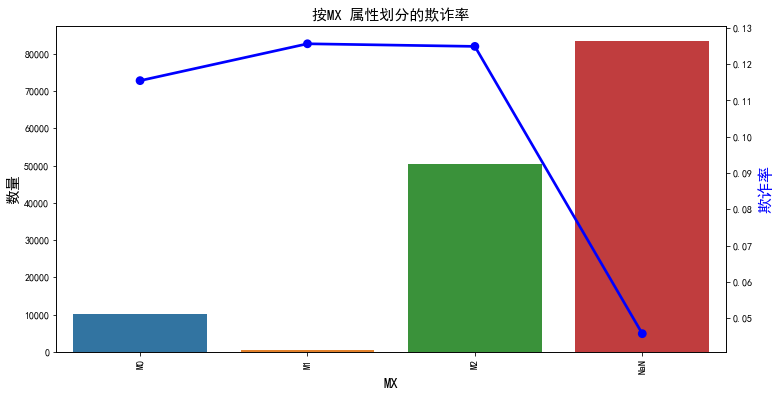

In [16]:
train_full['MX'] = train_full["M4"]
visualize_cat_cariable('MX')

<Figure size 432x288 with 0 Axes>

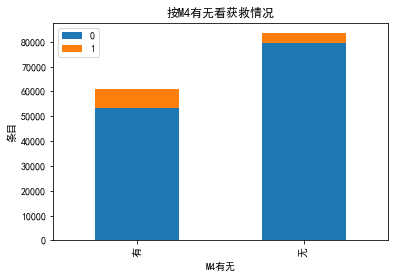

In [17]:
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

isFraud_M4 = train_full.isFraud[pd.notnull(train_full.M4)].value_counts()
isFraud_noM4 = train_full.isFraud[pd.isnull(train_full.M4)].value_counts()

df=pd.DataFrame({u'有':isFraud_M4, u'无':isFraud_noM4}).transpose()
df.plot(kind='bar', stacked=True)
plt.title(u"按M4有无看获救情况")
plt.xlabel(u"M4有无") 
plt.ylabel(u"条目")
plt.show()

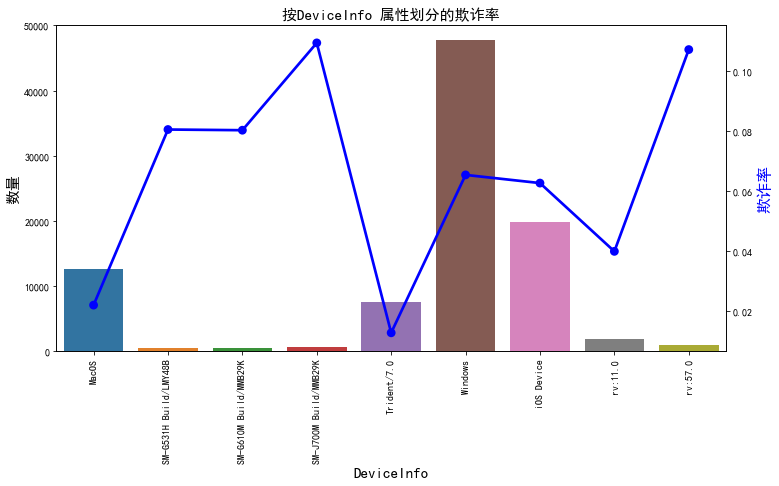

In [18]:
devicelist = train_full.groupby('DeviceInfo').filter(lambda x: len(x) >400)['DeviceInfo'].unique()
visualize_cat_cariable('DeviceInfo', df = train_full[train_full['DeviceInfo'].isin(devicelist)])

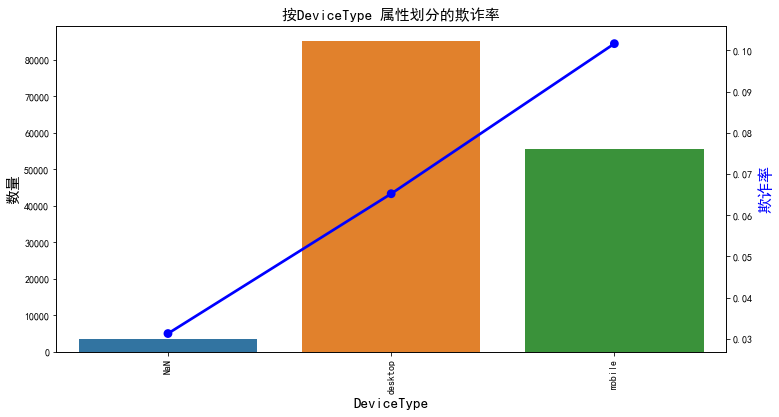

In [19]:
visualize_cat_cariable('DeviceType')

<Figure size 432x288 with 0 Axes>

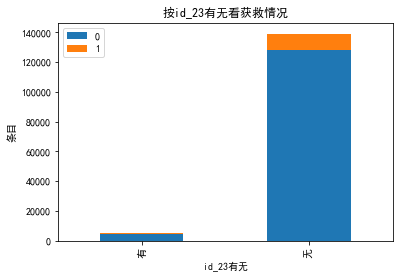

In [20]:
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

isFraud_id_23 = train_full.isFraud[pd.notnull(train_full.id_23)].value_counts()
isFraud_noid_23 = train_full.isFraud[pd.isnull(train_full.id_23)].value_counts()

df=pd.DataFrame({u'有':isFraud_id_23, u'无':isFraud_noid_23}).transpose()
df.plot(kind='bar', stacked=True)
plt.title(u"按id_23有无看获救情况")
plt.xlabel(u"id_23有无") 
plt.ylabel(u"条目")
plt.show()

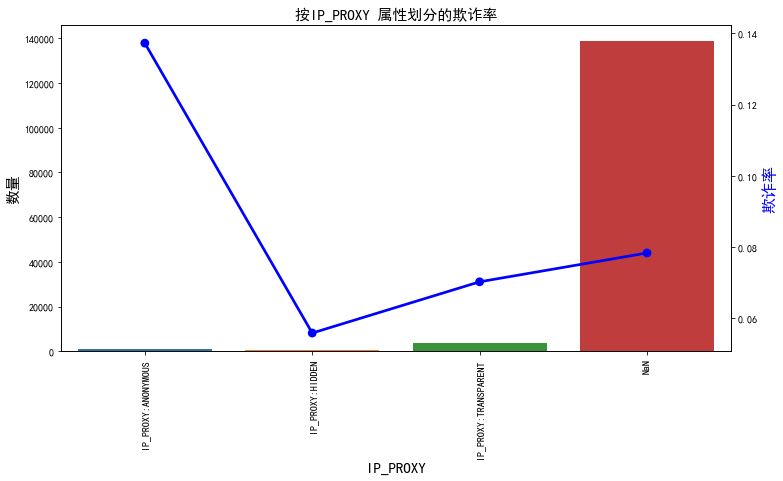

In [21]:
train_full['IP_PROXY'] = train_full["id_23"]
visualize_cat_cariable('IP_PROXY')

<Figure size 432x288 with 0 Axes>

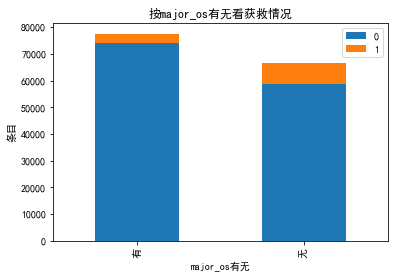

In [22]:
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

isFraud_major_os = train_full.isFraud[pd.notnull(train_full.id_30)].value_counts()
isFraud_nomajor_os = train_full.isFraud[pd.isnull(train_full.id_30)].value_counts()

df=pd.DataFrame({u'有':isFraud_major_os, u'无':isFraud_nomajor_os}).transpose()
df.plot(kind='bar', stacked=True)
plt.title(u"按major_os有无看获救情况")
plt.xlabel(u"major_os有无") 
plt.ylabel(u"条目")
plt.show()

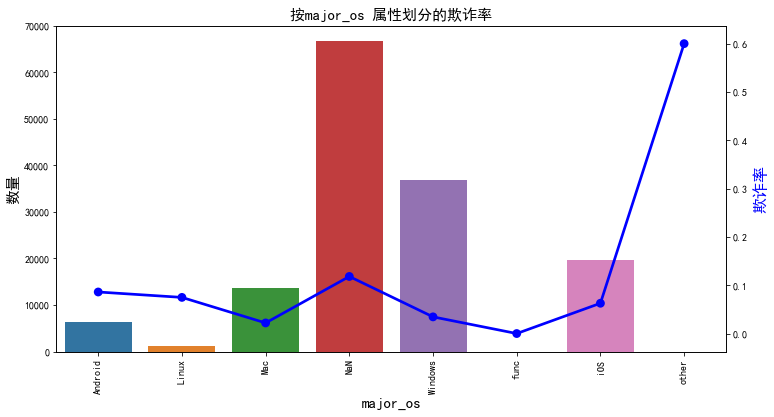

In [23]:
train_full['major_os'] = train_full["id_30"].str.split(' ', expand = True)[[0]]

visualize_cat_cariable('major_os')

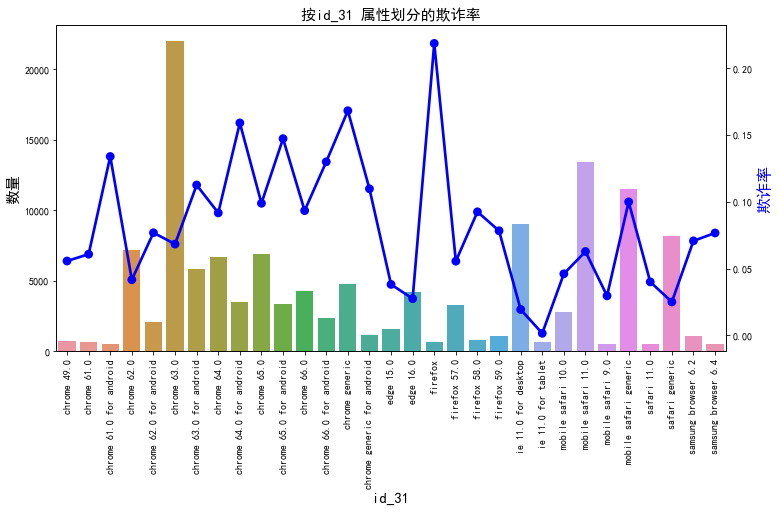

In [24]:
devicelist = train_full.groupby('id_31').filter(lambda x: len(x) >500)['id_31'].unique()
visualize_cat_cariable('id_31', df = train_full[train_full['id_31'].isin(devicelist)])

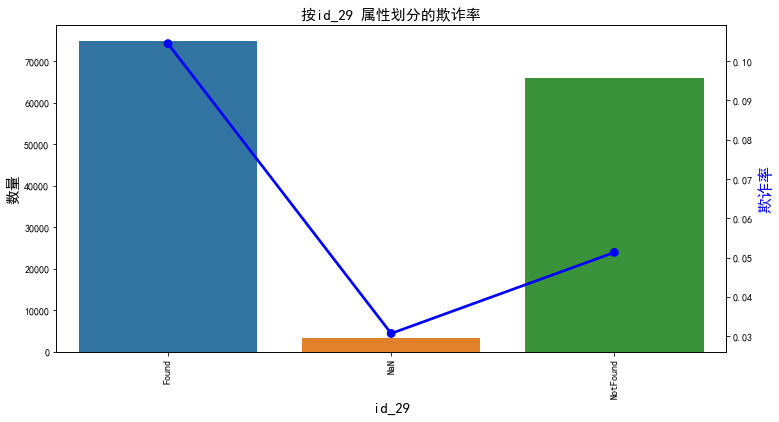

In [25]:
visualize_cat_cariable('id_29')

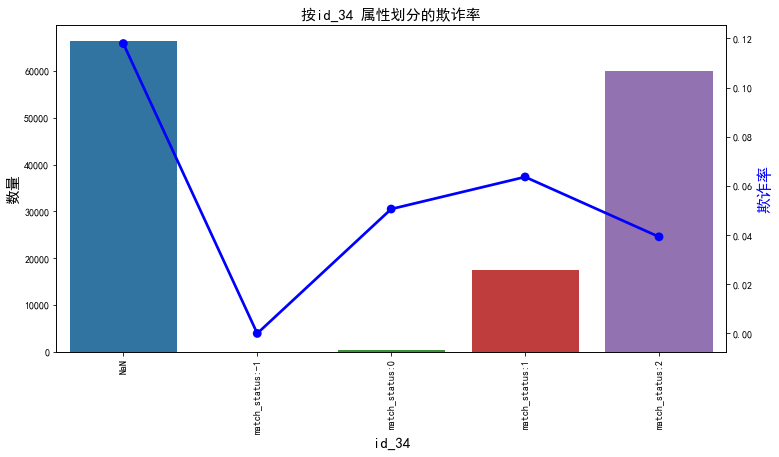

In [26]:
visualize_cat_cariable('id_34')

In [27]:
train_full.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,V333,V334,V335,V336,V337,V338,V339,MX,IP_PROXY,major_os
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,Android
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,iOS
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M0,NaN,NaN
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M0,NaN,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,Mac


In [52]:

#train_operation = pd.merge(train_identity, train_transaction, on = 'TransactionID')
train_operation['major_os'] = train_operation["id_30"].str.split(' ', expand = True)[[0]]
train_operation["P_parent_emaildomain"] = train_operation["P_emaildomain"].str.split('.', expand = True)[[0]]
train_operation["R_parent_emaildomain"] = train_operation["R_emaildomain"].str.split('.', expand = True)[[0]]
#train_operation['IP_PROXY'] = train_operation["id_23"]
train_operation['MX'] = train_operation["M4"]
def set_Some_type(df):
    df.loc[ (df.MX.notnull()), 'MX'] = "Yes"
    df.loc[ (df.MX.isnull()), 'MX' ] = "No"
    #df.loc[ (df.IP_PROXY.notnull()), 'IP_PROXY'] = "Yes"
    #df.loc[ (df.IP_PROXY.isnull()), 'IP_PROXY' ] = "No"
    df.loc[ (df.major_os.notnull()), 'major_os'] = "Yes"
    df.loc[ (df.major_os.isnull()), 'major_os' ] = "No"
    return df


In [53]:
train_operation = set_Some_type(train_operation)

In [54]:
train_operation.head(10)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D6,D7,D8,D9,D10,D12,D13,D14,D15,M4,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,major_os,MX,P_parent_emaildomain,R_parent_emaildomain
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,18.0,140.0,0.0,0.0,0.0,0.0,1803.0,49.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,15557.990234,169690.796875,0.0,0.0,0.0,515.0,5155.0,2840.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,No,gmail,NaN

In [55]:

dummies_MX = pd.get_dummies(data_train['MX'], prefix= 'MX')

#dummies_IP_PROXY = pd.get_dummies(data_train['IP_PROXY'], prefix= 'IP_PROXY')

dummies_major_os = pd.get_dummies(data_train['major_os'], prefix= 'major_os')

dummies_P_parent_emaildomain = pd.get_dummies(data_train['P_parent_emaildomain'], prefix= 'P_parent_emaildomain')

dummies_R_parent_emaildomain = pd.get_dummies(data_train['R_parent_emaildomain'], prefix= 'R_parent_emaildomain')

dummies_DeviceInfo = pd.get_dummies(data_train['DeviceInfo'], prefix= 'DeviceInfo')

dummies_DeviceType = pd.get_dummies(data_train['DeviceType'], prefix= 'DeviceType')

dummies_id_31 = pd.get_dummies(data_train['id_31'], prefix= 'id_31')


#df = pd.concat([data_train, dummies_MX, dummies_IP_PROXY, dummies_major_os, dummies_P_parent_emaildomain,dummies_R_parent_emaildomain,dummies_DeviceInfo,dummies_DeviceType,dummies_id_31], axis=1)
#df.drop(['MX', 'IP_PROXY', 'major_os', 'P_parent_emaildomain', 'R_parent_emaildomain', 'DeviceInfo','DeviceType','id_31'], axis=1, inplace=True)
df = pd.concat([data_train, dummies_MX, dummies_major_os, dummies_P_parent_emaildomain,dummies_R_parent_emaildomain,dummies_DeviceInfo,dummies_DeviceType,dummies_id_31], axis=1)
df.drop(['MX', 'major_os', 'P_parent_emaildomain', 'R_parent_emaildomain', 'DeviceInfo','DeviceType','id_31'], axis=1, inplace=True)
df.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_09  id_10  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    0.0    0.0   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    0.0    0.0   

   id_11     id_12  id_13  id_14  id_15     id_16  id_17  id_18  id_19  id_20  \
0  100.0  NotFound    NaN -480.0    New  NotFound  166.0    NaN  542.0  144.0   
1  100.0  NotFound   49.0 -300.0    New  NotFound  166.0    NaN  621.0  500.0   
2  100.0  NotFound   52.0    NaN  Found     Found  121.0    NaN  410.0  142.0   
3  100.0  NotFound   52.0    NaN    New  NotFound  225.0    NaN  176.0  507.0   
4  100.0  NotFound    NaN -300.0  Found     Found  166.0   15.0  529.0  575.0   

   id_28     id_29             id_30  id_32      id_33           id_34 id_35  \
0    New  NotFound       Android 7.0   32.0  2220x1080  match_status:2     T   
1    New  NotFound        iOS 11.1.2   32.0   1334x750  match_status:1     T   
2  Found     Found               NaN    NaN        NaN             NaN     F   
3    New  NotFound               NaN    NaN        NaN             NaN     F   
4  Found     Found  Mac OS X 10_11_6   24.0   1280x800  match_status:2     T   

  id_36 id_37 id_38  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0     F     T     T        0          86506          50.000         H   4497   
1     F     F     T        0          86535          15.000         H   2803   
2     F     T     T        0          86549          75.887         C  16496   
3     F     T     T        0          86555          16.495         C   4461   
4     F     T     T        0          86620          30.000         H   1790   

   card2  card3       card4  card5   card6  addr1  addr2  dist2  \
0  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN   
1  100.0  150.0        visa  226.0   debit  337.0   87.0    NaN   
2  352.0  117.0  mastercard  134.0  credit    NaN    NaN    NaN   
3  375.0  185.0  mastercard  224.0   debit    NaN    NaN   30.0   
4  555.0  150.0        visa  226.0   debit  170.0   87.0    NaN   

   P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0      gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   
1  anonymous.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   
2      gmail.com     gmail.com  1.0  4.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0   
3    hotmail.com   hotmail.com  1.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0   
4        aol.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12  C13  C14   D1   D4   D6   D7    D8   D9  D10  D12  D13  D14  \
0  1.0  1.0  0.0  1.0  1.0  0.0  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN   
1  1.0  1.0  0.0  1.0  1.0  0.0  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN   
2  1.0  2.0  2.0  2.0  1.0  1.0  0.0  0.0  0.0  83.0  0.0  0.0  0.0  0.0  0.0   
3  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  NaN   NaN  NaN  0.0  0.0  0.0  0.0   
4  1.0  1.0  0.0  1.0  1.0  0.0  NaN  NaN  NaN  26.0  0.0  NaN  NaN  NaN  NaN   

   D15   M4  V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2  0.0   M0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3  0.0   M0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V25  V26  V27  V28  V29  V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

In [56]:
from sklearn import linear_model


#train_df = df.filter(regex='isFraud|MX_.*|IP_PROXY_.*|major_os_.*|P_parent_emaildomain_.*|R_parent_emaildomain_.*|DeviceInfo_.*|DeviceType_.*|id_31_.*')
train_df = df.filter(regex='isFraud|MX_.*|major_os_.*|P_parent_emaildomain_.*|R_parent_emaildomain_.*|DeviceInfo_.*|DeviceType_.*|id_31_.*')
train_np = train_df.values

y = train_np[:, 0]

X = train_np[:, 1:]

clf = linear_model.LogisticRegression(solver='liblinear',C=1.0, penalty='l1', tol=1e-6)
clf.fit(X, y)

clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=1e-06, verbose=0,
                   warm_start=False)

In [57]:
#data_test=pd.merge(test_identity, test_transaction, on = 'TransactionID')

data_test.head(10)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D4,D6,D7,D8,D9,D10,D12,D13,D14,D15,M4,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13,18404013,6.271,C,15885,545.0,185.0,visa,138.0,debit,NaN,NaN,NaN,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,M2,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,1.0,1.0,1.0,1.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T,18404055,50.000,S,2453,399.0,150.0,american express,137.0,credit,49

In [58]:


data_test['major_os'] = data_test["id_30"].str.split(' ', expand = True)[[0]]
#data_test['IP_PROXY'] = data_test["id_23"]
data_test['MX'] = data_test["M4"]
data_test["P_parent_emaildomain"] = data_test["P_emaildomain"].str.split('.', expand = True)[[0]]
data_test["R_parent_emaildomain"] = data_test["R_emaildomain"].str.split('.', expand = True)[[0]]

data_test = set_Some_type(data_test)

dummies_MX = pd.get_dummies(data_test['MX'], prefix= 'MX')

#dummies_IP_PROXY = pd.get_dummies(data_test['IP_PROXY'], prefix= 'IP_PROXY')

dummies_major_os = pd.get_dummies(data_test['major_os'], prefix= 'major_os')

dummies_P_parent_emaildomain = pd.get_dummies(data_test['P_parent_emaildomain'], prefix= 'P_parent_emaildomain')

dummies_R_parent_emaildomain = pd.get_dummies(data_test['R_parent_emaildomain'], prefix= 'R_parent_emaildomain')

dummies_DeviceInfo = pd.get_dummies(data_test['DeviceInfo'], prefix= 'DeviceInfo')

dummies_DeviceType = pd.get_dummies(data_test['DeviceType'], prefix= 'DeviceType')

dummies_id_31 = pd.get_dummies(data_test['id_31'], prefix= 'id_31')

#df_test = pd.concat([data_train, dummies_MX, dummies_IP_PROXY, dummies_major_os, dummies_P_parent_emaildomain,dummies_R_parent_emaildomain,dummies_DeviceInfo,dummies_DeviceType,dummies_id_31], axis=1)
#df_test.drop(['MX', 'IP_PROXY', 'major_os', 'P_parent_emaildomain', 'R_parent_emaildomain', 'DeviceInfo','DeviceType','id_31'], axis=1, inplace=True)
df_test = pd.concat([data_test, dummies_MX, dummies_major_os, dummies_P_parent_emaildomain,dummies_R_parent_emaildomain,dummies_DeviceInfo,dummies_DeviceType,dummies_id_31], axis=1)
df_test.drop(['MX', 'major_os', 'P_parent_emaildomain', 'R_parent_emaildomain', 'DeviceInfo','DeviceType','id_31'], axis=1, inplace=True)
df_test.head()


TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_09  id_10  \
0        3663586  -45.0  280290.0    NaN    NaN    0.0    0.0    NaN    NaN   
1        3663588    0.0    3579.0    0.0    0.0    0.0    0.0    0.0    0.0   
2        3663597   -5.0  185210.0    NaN    NaN    1.0    0.0    NaN    NaN   
3        3663601  -45.0  252944.0    0.0    0.0    0.0    0.0    0.0    0.0   
4        3663602  -95.0  328680.0    NaN    NaN    7.0  -33.0    NaN    NaN   

   id_11     id_12  id_13  id_14  id_15     id_16  id_17  id_18  id_19  id_20  \
0  100.0  NotFound   27.0    NaN    New  NotFound  225.0   15.0  427.0  563.0   
1  100.0     Found    NaN -300.0  Found     Found  166.0    NaN  542.0  368.0   
2  100.0  NotFound   52.0 -360.0    New  NotFound  225.0    NaN  271.0  507.0   
3  100.0  NotFound   27.0    NaN  Found     Found  225.0   15.0  427.0  563.0   
4  100.0  NotFound   27.0    NaN    New  NotFound  225.0   15.0  567.0  507.0   

   id_28     id_29          id_30  id_32     id_33           id_34 id_35  \
0    New  NotFound            NaN    NaN       NaN             NaN     F   
1  Found     Found  Android 6.0.1   24.0  1280x720  match_status:2     T   
2    New  NotFound            NaN    NaN       NaN             NaN     F   
3  Found     Found            NaN    NaN       NaN             NaN     F   
4    New  NotFound            NaN    NaN       NaN             NaN     F   

  id_36 id_37 id_38  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0     F     T     F       18404013           6.271         C  15885  545.0   
1     F     T     T       18404055          50.000         S   2453  399.0   
2     T     T     F       18404235          37.318         C  15885  545.0   
3     F     T     F       18404315           6.271         C  15885  545.0   
4     F     T     F       18404359          52.258         C   9633  130.0   

   card3             card4  card5   card6  addr1  addr2  dist2  P_emaildomain  \
0  185.0              visa  138.0   debit    NaN    NaN    NaN    hotmail.com   
1  150.0  american express  137.0  credit  494.0   87.0   37.0            NaN   
2  185.0              visa  138.0   debit    NaN    NaN    NaN  anonymous.com   
3  185.0              visa  138.0   debit    NaN    NaN    NaN    hotmail.com   
4  185.0              visa  138.0   debit    NaN    NaN    NaN    hotmail.com   

   R_emaildomain   C1    C2   C3   C4   C5   C6   C7    C8   C9   C10   C11  \
0    hotmail.com  1.0   1.0  0.0  1.0  0.0  1.0  1.0   1.0  0.0   1.0   1.0   
1      gmail.com  4.0   8.0  0.0  4.0  0.0  0.0  0.0  25.0  0.0  30.0   5.0   
2  anonymous.com  1.0   1.0  0.0  1.0  0.0  1.0  1.0   1.0  0.0   1.0   1.0   
3    hotmail.com  2.0   4.0  0.0  3.0  0.0  3.0  3.0   3.0  0.0   3.0   3.0   
4    hotmail.com  8.0  21.0  0.0  4.0  0.0  4.0  4.0   5.0  0.0   6.0  11.0   

    C12   C13  C14    D1     D4     D6     D7    D8   D9    D10    D12  D13  \
0   1.0   0.0  0.0   NaN    0.0    0.0    NaN   NaN  NaN    0.0    0.0  0.0   
1   0.0  57.0  4.0  34.0    NaN  634.0    1.0  22.0  0.0  458.0    NaN  NaN   
2   1.0   1.0  1.0   NaN    0.0    0.0    NaN   NaN  NaN    0.0    0.0  0.0   
3   3.0   2.0  1.0   NaN  567.0  567.0  288.0   0.0  0.0    0.0  567.0  0.0   
4  11.0  10.0  6.0   NaN  316.0  316.0    2.0   NaN  NaN    0.0  316.0  0.0   

   D14    D15   M4  V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  \
0  0.0    0.0   M2  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
1  NaN  634.0  NaN  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0   
2  0.0    0.0   M2  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3  0.0    0.0   M2  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4  NaN   12.0   M2  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

   V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  V34  V35  V36  V37  \
0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0   
1  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.

In [60]:
#test = df_test.filter(regex='isFraud|MX_.*|IP_PROXY_.*|major_os_.*|P_parent_emaildomain_.*|R_parent_emaildomain_.*|DeviceInfo_.*|DeviceType_.*|id_31_.*')
test = df_test.filter(regex='isFraud|MX_.*|major_os_.*|P_parent_emaildomain_.*|R_parent_emaildomain_.*|DeviceInfo_.*|DeviceType_.*|id_31_.*')

predictions = clf.predict(test)
result = pd.DataFrame({'TransactionID':data_test['TransactionID'].values, 'isFraud':predictions.astype(np.int32)})
result.to_csv("./CIS Fraud Detection_Result.csv", index=False)

ValueError: X has 2457 features per sample; expecting 2011